## Loading modules and the dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import xgboost
import bs4
import re

In [2]:
# Dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")

## Linking the questions labels to the questions title
Using the HTML file, we can access to labels questions which gathered additional information to know how to use these data

In [44]:
html_file = "data/USCODE22_LLCP_102523.HTML"
out_csv = "data/labels_questions.csv"

# Reading HTML 
with open(html_file, encoding="latin-1") as f:
    html = f.read()

soup = bs4.BeautifulSoup(html, "html.parser")

# Extracting blocks of questions
questions = []

for td in soup.find_all("td", class_="l m linecontent"):
    text = td.get_text(separator=" ", strip=True)
    text = text.replace("\xa0", " ")  
    text = re.sub(r"\s+", " ", text)

    # Extracting the different information
    label_match = re.search(r"Label:\s(.*?)\s+(?:Section Name:|Core Section Name:)", text, re.IGNORECASE)
    section_name_match = re.search(r"(?:Section Name:|Core Section Name:)\s(.*?)\s+(?:Section Number:|Core Section Number:|Module Number:)", text, re.IGNORECASE)
    section_number_match = re.search(r"(?:Section Number:|Core Section Number:|Module Number:)\s*([0-9A-Za-z]+)", text, re.IGNORECASE)
    sas_match = re.search(r"SAS Variable Name:\s*([A-Za-z0-9_]+)", text, re.IGNORECASE)

    questions.append({
        "Label": label_match.group(1).strip() if label_match else "",
        "Section Name": section_name_match.group(1).strip() if section_name_match else "",
        "Section Number": section_number_match.group(1).strip() if section_number_match else "", 
        "SAS_Variable_Name": sas_match.group(1).strip() if sas_match else ""
        })

# Conversion to df
labels_questions_df = pd.DataFrame(questions)

# Saving labels df
labels_questions_df.to_csv(out_csv, index=False, encoding="utf-8")

In [ ]:
# Which are the different sections
labels_questions_df["Section Name"].unique()

array(['Record Identification', 'Land Line Introduction',
       'Cell Phone Introduction', 'Respondent Sex', 'Health Status',
       'Healthy Days', 'Health Care Access', 'Exercise',
       'Inadequate Sleep', 'Oral Health', 'Chronic Health Conditions',
       'Demographics', 'Disability',
       'Breast and Cervical Cancer Screening',
       'Colorectal Cancer Screening', 'Tobacco Use',
       'Lung Cancer Screening', 'Alcohol Consumption', 'Immunization',
       'HIV/AIDS', 'Long-term COVID Effects', 'Pre-Diabetes', 'Diabetes',
       'ME/CFS', 'Place of Flu Vaccination', 'HPV Vaccination',
       'Shingles Vaccination', 'COVID Vaccination', 'Respiratory Health',
       'Cancer Survivorship: Type of Cancer',
       'Cancer Survivorship: Course of Treatment',
       'Cancer Survivorship: Pain Management',
       'Prostate Cancer Screening', 'Cognitive Decline', 'Caregiver',
       'Adverse Childhood Experiences',
       'Social Determinants and Health Equity', 'Marijuana Use',
      

In [ ]:
# Which are the different sections
len(labels_questions_df["Section Name"].unique())

56

In [64]:
# Removing useless sections
section_to_remove = ['Record Identification', 
                    'Questionnaire Version',
                    'Questionnaire Language']

sas_variable_associated = labels_questions_df[labels_questions_df["Section Name"].isin(section_to_remove)]["SAS_Variable_Name"].to_list()

labels1_questions_df = labels_questions_df[~labels_questions_df['Section Name'].isin(section_to_remove)].reset_index(drop=True)
original1_df = original_df.copy().drop(sas_variable_associated, axis=1)

print(f"Removed {original_df.shape[1] - original1_df.shape[1]} features : from {original_df.shape[1]} to {original1_df.shape[1]}")

Removed 11 features : from 325 to 314


Remove full NaN columns

In [70]:
# Removing full Nan columns
cols_all_nan = original1_df.columns[original1_df.isna().all()].tolist()

# Drop the columns and the lines in the label file
original2_df = original1_df.drop(cols_all_nan, axis=1)
labels2_questions_df = labels1_questions_df[~labels1_questions_df['SAS_Variable_Name'].isin(cols_all_nan)].reset_index(drop=True)

print(f"Removed {original1_df.shape[1] - original2_df.shape[1]} features : from {original1_df.shape[1]} to {original2_df.shape[1]}")
print(labels1_questions_df.shape)
print(labels2_questions_df.shape)

Removed 3 features : from 314 to 311
(313, 4)
(310, 4)


Merging similar questions

In [115]:
# Checking for duplicates 
dup_counts = labels2_questions_df['Label'].value_counts()
duplicates = dup_counts[dup_counts > 1]

print(f"Unique labels: {dup_counts.shape[0]}")
print(f"Duplicate labels: {duplicates.shape[0]}")

if duplicates.empty:
    print("No duplicates")
else:
    print("\nDuplicates & Occurrences:")
    print(duplicates)

    # Corresponding line
    dup_rows = labels2_questions_df[labels2_questions_df['Label'].isin(duplicates.index)].sort_values('Label').reset_index(drop=True)
    print("\nLines Duplicates:")
    print(dup_rows)

Unique labels: 303
Duplicate labels: 5

Duplicates & Occurrences:
Label
Are you male or female?              4
Do you live in college housing?      2
Sexual orientation                   2
Are you 18 years of age or older?    2
Number of Adults in Household        2
Name: count, dtype: int64

Lines Duplicates:
                                Label  \
0   Are you 18 years of age or older?   
1   Are you 18 years of age or older?   
2             Are you male or female?   
3             Are you male or female?   
4             Are you male or female?   
5             Are you male or female?   
6     Do you live in college housing?   
7     Do you live in college housing?   
8       Number of Adults in Household   
9       Number of Adults in Household   
10                 Sexual orientation   
11                 Sexual orientation   

                                     Section Name Section Number  \
0                          Land Line Introduction              0   
1                 

In [ ]:
# Merging Similar Label questions : Are you 18 years of age or older? 
complementary_check = ((original2_df["LADULT1"].notna() & original2_df["CADULT1"].isna()) |
                       (original2_df["LADULT1"].isna() & original2_df["CADULT1"].notna()))

merged_column = original2_df["LADULT1"].fillna(0) + original2_df["CADULT1"].fillna(0) # -> column is almost constant, let's remove both -> meaning we can remove in the end LandLine & CellPhone

In [89]:
# Merging sex column
cols = ["COLGSEX1", "LANDSEX1", "CELLSEX1", "BIRTHSEX"]

complementary_check = original2_df[cols].notna().sum(axis=1) == 1

print(complementary_check.describe())
merged_column = original2_df["COLGSEX1"].fillna(0) + original2_df["LANDSEX1"].fillna(0) + original2_df["CELLSEX1"].fillna(0) + original2_df["BIRTHSEX"].fillna(0)

# Keeping label : BIRTHSEX
original3_df = original2_df.copy()
original3_df["BIRTHSEX"] = merged_column

count     225000
unique         2
top        False
freq      199063
dtype: object


In [91]:
# Removing useless sections
section_to_remove = ['Land Line Introduction', 
                    'Cell Phone Introduction']

sas_variable_associated = labels2_questions_df[labels2_questions_df["Section Name"].isin(section_to_remove)]["SAS_Variable_Name"].to_list()

labels4_questions_df = labels2_questions_df[~labels2_questions_df['Section Name'].isin(section_to_remove)].reset_index(drop=True)
original4_df = original3_df.copy().drop(sas_variable_associated, axis=1)

print(f"Removed {original3_df.shape[1] - original4_df.shape[1]} features : from {original3_df.shape[1]} to {original4_df.shape[1]}")

Removed 22 features : from 311 to 289


In [95]:
print(labels4_questions_df["Section Name"].unique())

['Respondent Sex' 'Health Status' 'Healthy Days' 'Health Care Access'
 'Exercise' 'Inadequate Sleep' 'Oral Health' 'Chronic Health Conditions'
 'Demographics' 'Disability' 'Breast and Cervical Cancer Screening'
 'Colorectal Cancer Screening' 'Tobacco Use' 'Lung Cancer Screening'
 'Alcohol Consumption' 'Immunization' 'HIV/AIDS' 'Long-term COVID Effects'
 'Pre-Diabetes' 'Diabetes' 'Place of Flu Vaccination' 'HPV Vaccination'
 'Shingles Vaccination' 'COVID Vaccination' 'Respiratory Health'
 'Cancer Survivorship: Type of Cancer'
 'Cancer Survivorship: Course of Treatment'
 'Cancer Survivorship: Pain Management' 'Prostate Cancer Screening'
 'Cognitive Decline' 'Caregiver' 'Adverse Childhood Experiences'
 'Social Determinants and Health Equity' 'Marijuana Use'
 'Tobacco Cessation' 'Other Tobacco Use'
 'Alcohol Screening & Brief Intervention (ASBI)' 'Firearm Safety'
 'Random Child Selection' 'Childhood Asthma Prevalence' 'Sex at Birth'
 'Sexual Orientation and Gender Identity (SOGI)' 'Family 

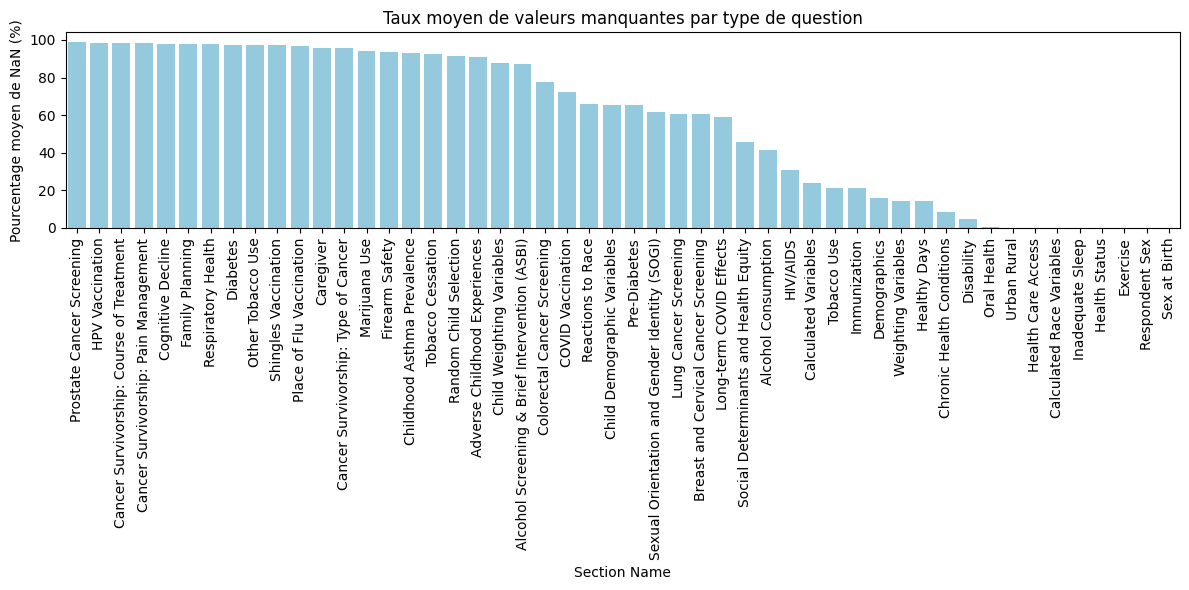

In [99]:
# Looking for how many columns have Nan and in which quantity, in each label

# Computing Nan percentage
nan_percent = original4_df.isna().mean() * 100
nan_percent = nan_percent.reset_index()
nan_percent.columns = ["SAS_Variable_Name", "NaN_percent"]

# Merging tables
merged = nan_percent.merge(
    labels4_questions_df[["SAS_Variable_Name", "Section Name"]],
    on="SAS_Variable_Name",
    how="left"
)

# Mean for each label group and sorting
nan_by_type = merged.groupby("Section Name")["NaN_percent"].mean().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(
    data=nan_by_type.reset_index(),
    x="Section Name", y="NaN_percent",
    color="skyblue"
)
plt.xticks(rotation=90)
plt.ylabel("Pourcentage moyen de NaN (%)")
plt.title("Taux moyen de valeurs manquantes par type de question")
plt.tight_layout()
plt.show()

/var/folders/0x/tnwyycrs76jb4wzv1753ymx40000gn/T/ipykernel_97756/2898495939.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


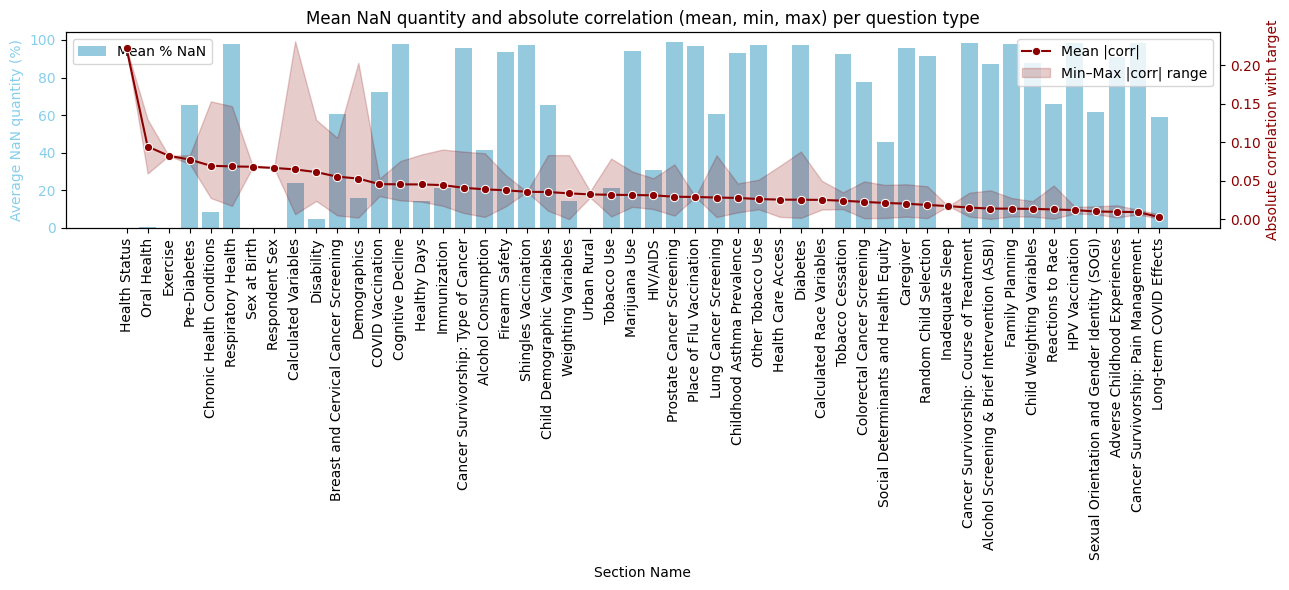

In [116]:
# Nan percentages
nan_percent = original4_df.isna().mean() * 100
nan_percent = nan_percent.reset_index()
nan_percent.columns = ["SAS_Variable_Name", "NaN_percent"]

# Correlation with target
corrs = []
target = original4_df["TARGET"]

for col in original4_df.columns:
    if col == "TARGET":
        continue
    try:
        if pd.api.types.is_numeric_dtype(original4_df[col]):
            corr = original4_df[col].corr(target)
            corrs.append((col, corr))
        else:
            corrs.append((col, np.nan))
    except Exception:
        corrs.append((col, np.nan))

corr_df = pd.DataFrame(corrs, columns=["SAS_Variable_Name", "corr_with_target"])

# Merging tables
merged = (
    nan_percent
    .merge(corr_df, on="SAS_Variable_Name", how="left")
    .merge(labels4_questions_df[["SAS_Variable_Name", "Section Name"]],
           on="SAS_Variable_Name", how="left")
)

# Mean for each type of questions
summary = merged.groupby("Section Name").agg(
    mean_nan_percent=("NaN_percent", "mean"),
    mean_abs_corr=("corr_with_target", lambda x: np.nanmean(np.abs(x))),
    min_abs_corr=("corr_with_target", lambda x: np.nanmin(np.abs(x))),
    max_abs_corr=("corr_with_target", lambda x: np.nanmax(np.abs(x)))
).sort_values("mean_abs_corr", ascending=False)

# Visualization
fig, ax1 = plt.subplots(figsize=(13,6))

# Bar plot for mean NaN %
sns.barplot(
    data=summary.reset_index(),
    x="Section Name", y="mean_nan_percent",
    color="skyblue", label="Mean % NaN", ax=ax1
)
ax1.set_ylabel("Average NaN quantity (%)", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Line plot for mean correlation
ax2 = ax1.twinx()
sns.lineplot(
    data=summary.reset_index(),
    x="Section Name", y="mean_abs_corr",
    color="darkred", marker="o", label="Mean |corr|", ax=ax2
)

# Add min and max as shaded area or lines
ax2.fill_between(
    range(len(summary)),
    summary["min_abs_corr"],
    summary["max_abs_corr"],
    color="darkred",
    alpha=0.2,
    label="Min–Max |corr| range"
)

ax2.set_ylabel("Absolute correlation with target", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("Mean NaN quantity and absolute correlation (mean, min, max) per question type")
fig.tight_layout()
plt.legend(loc="upper right")
plt.show()

In [148]:
selected_label = [
    "Health Status",
    "Oral Health",
    "Exercise",
    "Chronic Health Conditions",
    "Sex at Birth",
    "Respondent Sex",
    "Disability",
    "Calculated Variables",
    "Demographics",
    "Healthy Days",
    "Immunization"
]

# Filtering the questions
selected_questions = labels4_questions_df[
    labels4_questions_df["Section Name"].isin(selected_label)
]["SAS_Variable_Name"]

# Number of questions
num_questions = len(selected_questions)

print(f"Number of labels : {len(selected_label)}")
print(f"Number questions : {num_questions}")

Number of labels : 11
Number questions : 99


In [149]:
print(len(selected_questions))
selected_questions = [quest for quest in selected_questions if quest not in ['CVDINFR4', 'CVDCRHD4', '_MICHD']]
print(len(selected_questions))


99
96


/var/folders/0x/tnwyycrs76jb4wzv1753ymx40000gn/T/ipykernel_97756/2039647005.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


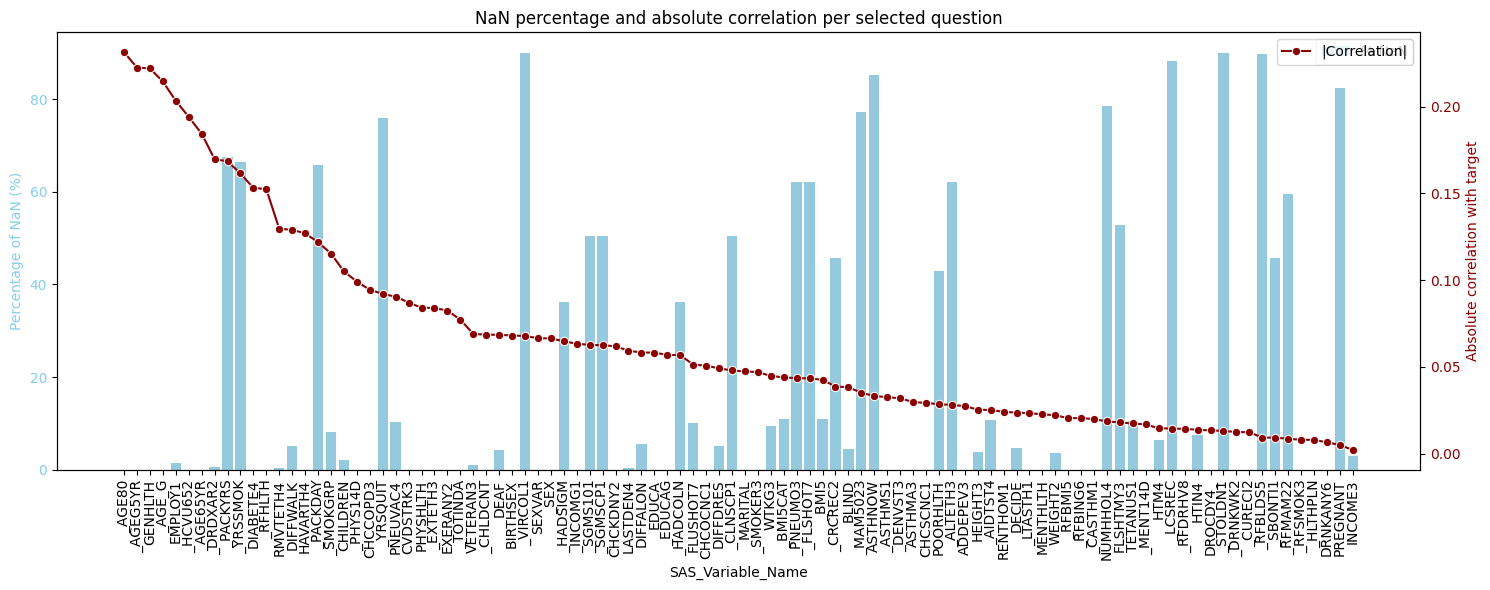

In [150]:
# Nan Percentages
nan_percent = original4_df[selected_questions].isna().mean() * 100
nan_percent = nan_percent.reset_index()
nan_percent.columns = ["SAS_Variable_Name", "NaN_percent"]

# Correlation
corrs = []
target = original4_df["TARGET"]

for col in selected_questions:
    try:
        if pd.api.types.is_numeric_dtype(original4_df[col]):
            corr = original4_df[col].corr(target)
            corrs.append((col, corr))
        else:
            corrs.append((col, np.nan))
    except Exception:
        corrs.append((col, np.nan))

corr_df = pd.DataFrame(corrs, columns=["SAS_Variable_Name", "corr_with_target"])
corr_df["abs_corr"] = corr_df["corr_with_target"].abs()

# Merging
feature_stats = nan_percent.merge(corr_df, on="SAS_Variable_Name", how="left")

# Sorting by correlation
feature_stats = feature_stats.sort_values("abs_corr", ascending=False)

# Visualization
fig, ax1 = plt.subplots(figsize=(15,6))

# Bar plot: % NaN
sns.barplot(
    data=feature_stats,
    x="SAS_Variable_Name",
    y="NaN_percent",
    color="skyblue",
    ax=ax1,
    label="% NaN"
)
ax1.set_ylabel("Percentage of NaN (%)", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Line plot: abs correlation
ax2 = ax1.twinx()
sns.lineplot(
    data=feature_stats,
    x="SAS_Variable_Name",
    y="abs_corr",
    color="darkred",
    marker="o",
    label="|Correlation|",
    ax=ax2
)
ax2.set_ylabel("Absolute correlation with target", color="darkred")
ax2.tick_params(axis='y', labelcolor="darkred")

plt.title("NaN percentage and absolute correlation per selected question")
fig.tight_layout()
plt.show()
